# $A_{\rm{eff}}$ in rate factor


In [219]:
import numpy as np
import stan_utility
from matplotlib import pyplot as plt
import corner

In [220]:
random_seed = 19920715

## The idea

Consider a inhomogeneous poisson point process over 2 sources in 1D space (x-axis). Events are detected from the two sources with some uncertainty. The produced events have associated energies, with uniform probabilities. Our "detector" has an effective area as a function of position, $x$ and energy $E$.

The likelihood:
$$
e^{-\bar{N}} \prod_i \sum_k w_k  A_{\rm{eff}}(E_i, x_i) p(E_i | E_{\rm{min}}, E_{\rm{max}}) p(x_i | \mu_k, \sigma),
$$

Where 
$$
\bar{N}_k = \int {\rm{d}}x \int {\rm{d}}E \ A_{\rm{eff}}(x, E) \frac{{\rm{d}} N}{ {\rm{d}}x {\rm{d}}E },
$$


$$
\bar{N} = \sum_k \bar{N}_k,
$$
with $x \sim N(\mu, \sigma)$ and $E \sim U(E_{\rm{min}}, E_{\rm{max}})$.

We want to identify the mixture weights $w_k$, and the individual association probabilities. The effect of leaving out $A_{\rm{eff}}$ from the rate factor of the likelihood should be made explicit.

## Simple demonstration

To keep things simple, consider that the $A_\rm{eff}$ effects in $x$ and $E$ are independent. Then treat the $A_{\rm{eff}}(x)$ as a simple "area weight" over each source that is predefined. Then $A_{\rm{eff}}(E)$ is a step function at $E_{\rm{th}}^k$ which is different for different sources.

So we have:
$$
\bar{N}_k = w_k \frac{ {\rm{d}}N }{ {\rm{d}}E } (E_{\rm{max}} - E_{\rm{min}})
$$

We fit for the case of including the energy step function, and ignoring it.

## Simulate some data

In [221]:
# Compile the model
sim = stan_utility.compile_model(filename = 'aeff_in_rate_factor_sim.stan', 
                                 model_name = 'aeff_in_rate_factor', 
                                 include_paths = 'stan/')

Using cached StanModel


In [235]:
# Simulate
sim_input = {}
sim_input['Ncomp'] = 2
sim_input['mu'] = [10, 20]
sim_input['sigma'] = 5
sim_input['area_weight'] = [0.3, 0.7]
sim_input['Eth'] = [1, 50]
sim_input['Emax'] = 100
sim_input['dNdE'] = 4

simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed = random_seed)


location = simulation.extract('location')['location'][0]
energy = simulation.extract('energy')['energy'][0]
label = simulation.extract('label')['label'][0]
weight = simulation.extract('weight_out')['weight_out'][0]

print('N: ', len(location))
print('true weight: ', weight)

N:  286
true weight:  [0.45904173 0.54095827]


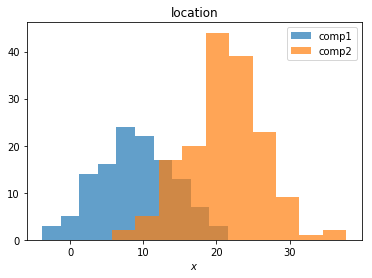

In [236]:
# plot the detected locations from the two components
fig, ax = plt.subplots()
ax.hist(location[label == 1], alpha=0.7, label='comp1')
ax.hist(location[label == 2], alpha=0.7, label='comp2')
ax.set_xlabel('$x$')
ax.set_title('location')
ax.legend();

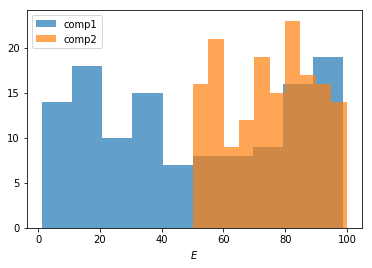

In [237]:
# plot detected energies
fig, ax = plt.subplots()
ax.hist(energy[label == 1], label='comp1', alpha=0.7)
ax.hist(energy[label == 2], label='comp2', alpha=0.7)
ax.set_xlabel('$E$')
ax.legend();

## Fit the data

In [238]:
# Compile the model
model = stan_utility.compile_model(filename = 'aeff_in_rate_factor_model.stan', 
                                   model_name = 'aeff_in_rate_factor', 
                                   include_paths = 'stan/')

Using cached StanModel


In [239]:
fit_input = {}
fit_input['Ncomp'] = sim_input['Ncomp']
fit_input['sigma'] = sim_input['sigma']
fit_input['Emax'] = sim_input['Emax']
fit_input['Eth'] = sim_input['Eth']
fit_input['dNdE'] = sim_input['dNdE']
fit_input['mu'] = sim_input['mu']
fit_input['area_weight'] = sim_input['area_weight']
fit_input['N'] = len(location)
fit_input['location'] = location
fit_input['energy'] = energy

fit_input['include_energy'] = 1

#### First without the $A_{\rm{eff}}$...

In [240]:
fit_input['extra_factor'] = 0
fit_without = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

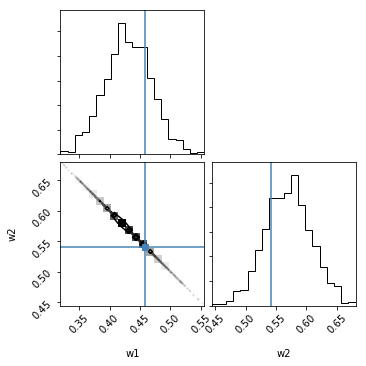

In [241]:
# Compare fit weight and true weight
chain = fit_without.extract(permuted = True)
w = chain['weight'].T
corner.corner(np.column_stack([w[0], w[1]]), labels=['w1', 'w2'], 
              truths=[weight[0], weight[1]]);

In [242]:
# Calculate association probabilities for each source-neutrino combo
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]
Ns = np.shape(logprob)[1]
p = []
for lp in logprob:
    lps = []
    for src in range(Ns):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns):
        ps.append(lps[src] / norm)
    p.append(ps)

# Normalise line weights
pmax = max(max(p))

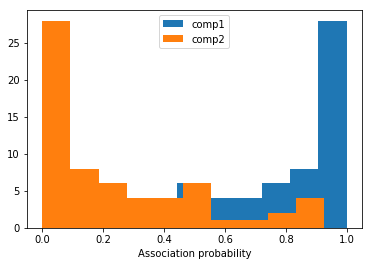

In [243]:
# Plot associatio probabilities of events with energies below E_th of the component with the energy cut
energy_below_th = energy[energy < sim_input['Eth'][1]]
inds = np.where(energy < sim_input['Eth'][1])[0]
p_select = [p[_] for _ in inds]

fig, ax = plt.subplots()
ax.hist(np.array(p_select).T[0], label='comp1')
ax.hist(np.array(p_select).T[1], label='comp2')
ax.legend();
ax.set_xlabel('Association probability');

#### So, weights are fit correctly, but some events which have $E < E_{\rm{th}}$ have non zeros assocation with comp2... not physical!

#### Let's fix this by including the factor

In [244]:
fit_input['extra_factor'] = 1
fit_with = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

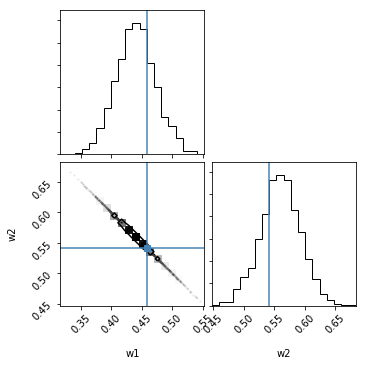

In [245]:
# Compare fit weight and true weight
chain = fit_with.extract(permuted = True)
w = chain['weight'].T
corner.corner(np.column_stack([w[0], w[1]]), labels=['w1', 'w2'], 
              truths=[weight[0], weight[1]]);

In [246]:
# Calculate association probabilities for each source-neutrino combo
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]
Ns = np.shape(logprob)[1]
p = []
for lp in logprob:
    lps = []
    for src in range(Ns):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns):
        ps.append(lps[src] / norm)
    p.append(ps)

# Normalise line weights
pmax = max(max(p))

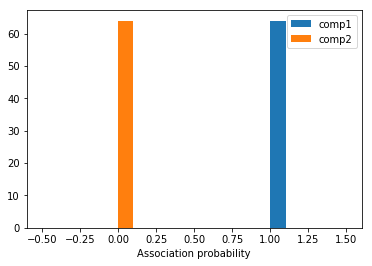

In [247]:
# Plot associatio probabilities of events with energies below E_th of the component with the energy cut
energy_below_th = energy[energy < sim_input['Eth'][1]]
inds = np.where(energy < sim_input['Eth'][1])[0]
p_select = [p[_] for _ in inds]

fig, ax = plt.subplots()
ax.hist(np.array(p_select).T[0], label='comp1')
ax.hist(np.array(p_select).T[1], label='comp2')
ax.legend()
ax.set_xlabel('Association probability');

#### Summary - ignoring this, we can recover the correct weights, but not the correct association probabilities.